### Imports

In [1]:
import struct

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, timezone

from matplotlib import mlab
from scipy.fft import fft, ifft, fftshift, ifftshift, ifft2, fft2, fftfreq
from scipy.spatial.transform import Rotation
from scipy.signal import resample
from scipy.interpolate import interp1d
from scipy.optimize import root, fsolve
from scipy.ndimage import shift
from scipy.ndimage import map_coordinates

from decoding import get_header_dict, packet_generator_from_file, packet_generator, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation
from structs import SUB_COMM_KEY_POS, SUB_COMM_KEY_VAL, WORD_SIZE, F_REF

### Constants

In [2]:
from scipy.constants import pi, c

range_sampling_rate = 6.434523812571428e+07
s1_center_freq = 5.405000454334350e+09
s1_wavelength = c / s1_center_freq

earth_sidereal = [0, 0, 0.00007292115833]  # rad/s
wgs84_major_a = 6_378_137.0
wgs84_minor_b = 6_356_752.3142
wgs84_eccentricity = 0.0067395

### Plotting

In [3]:
def norm(image):
    return np.abs(image) / np.max(np.abs(image))

def plot_signals(signals, title="", xlabel="", ylabel="", aspect="auto", do_norm=True, do_pop_out=False):

    if do_pop_out:
        %matplotlib qt
    else:
        %matplotlib inline

    # signals = norm(signals)
    signals = np.abs(signals)
    mean = np.mean(signals)
    std = 4 * np.std(signals)
    vmin =  0 # mean - std
    vmax = mean + std
    
    fig = plt.figure()
    fig.set_size_inches(12, 3)
    plt.imshow(signals, cmap='jet', aspect=aspect, origin="lower", vmin=vmin, vmax=vmax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def plot_signal_components(signal, scale=(None, None), fft_size=128, sample_rate=None, title="", size=(6, 12), times=None, Fc=None):
    if times is None:
        start_time = 0
        end_time = start_time + signal.shape[0]
        t = np.linspace(0, end_time, signal.shape[0])
    else:
        t = times
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(size[1], size[0]))
    ax1.plot(t, signal.imag, linewidth=0.75, label='Imaginary Part', color="red")
    ax1.plot(t, signal.real, linewidth=0.75, label='Real Part', color="darkblue")
    ax1.set_title(title)
    ax1.set_xlabel("Time (us)")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="lower right")
    ax1.grid(True)
    ax1.set_xlim([t[0], t[-1]])
    ax2.plot(t, np.unwrap(np.angle(signal)), linewidth=0.75, color="red")
    ax2.set_xlabel("Time (us)")
    ax2.set_ylabel("Phase")
    ax2.grid(True)
    ax2.set_xlim([t[0], t[-1]])
    if scale is not None:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, Fc=Fc, noverlap=fft_size-1, cmap='seismic', vmin=scale[0], vmax=scale[1], window=mlab.window_hanning, aspect='equal')
    else:
        ax3.specgram(signal, NFFT=fft_size, Fs=sample_rate, Fc=Fc, noverlap=fft_size-1, cmap='seismic', aspect='equal')
    ax3.set_xlabel("Time (us)")
    ax3.set_ylabel("Frequency")
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

def save_image(img_data, filename):
    img = np.abs(img_data) / np.max(np.abs(img_data))
    from PIL import Image
    im = Image.fromarray(img)
    im.save(filename)

### Decoding

In [4]:
def get_packets_in_swath(data, swath_num):
    PacketGenerator = packet_generator(data)
    swath_packets = []
    packet_index = 0
    while (data):
        try:
            packet = next(PacketGenerator)
            if packet.data_format() == 'D':
                if packet.get_secondary_header()['swath_number'] == swath_num:
                    swath_packets.append((packet, packet_index))
            packet_index += 1
        except ValueError as ve:
            break
    return swath_packets

def get_packets_in_bursts(swath_packets):
    bursts = []
    burst_packets = []
    previous_az = 0
    index = 0
    for packet, packet_index in swath_packets:
        az = packet.get_secondary_header()['azimuth_beam_address']
        if index == 0:
            previous_az = az
        if az != previous_az and az != previous_az + 1:
            bursts.append(burst_packets)
            burst_packets = []
        burst_packets.append((packet, packet_index))
        previous_az = az
        if index == len(swath_packets) - 1:
            bursts.append(burst_packets)
        index += 1
    return bursts

def get_packets_in_burst(swath_packets, burst_num):
    bursts = get_packets_in_bursts(swath_packets)
    return bursts[burst_num]

def get_all_data_packets_from_file(filename):
    packets = []
    indexes = []
    index = 0
    with open(filename, 'rb') as data:
        PacketGenerator = packet_generator(data)
        while (data):
            try:
                packet = next(PacketGenerator)
                packets.append(packet)
                indexes.append(index)
                index += 1
            except ValueError as ve:
                break
    return packets, indexes

### State Vectors

In [5]:
def mjd2000_time_to_datetime(gps_time_seconds):
    mjd2000_epoch = datetime(2000, 1, 1, tzinfo=timezone(timedelta(0)))
    current_time = gps_epoch + timedelta(seconds=gps_time_seconds)

def gps_time_to_datetime(gps_time_seconds):
    # GPS epoch is January 6, 1980, 00:00:00 UTC
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    current_time = gps_epoch + timedelta(seconds=gps_time_seconds)
    return current_time
    
def gps_time_to_seconds_since_midnight(gps_time_seconds):
    # GPS epoch is January 6, 1980, 00:00:00 UTC
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    whole_seconds = int(gps_time_seconds)
    fractional_seconds = gps_time_seconds - whole_seconds
    current_time = gps_epoch + timedelta(seconds=whole_seconds)
    seconds_since_midnight = (
        current_time.hour * 3600 +
        current_time.minute * 60 +
        current_time.second +
        fractional_seconds
    )
    return seconds_since_midnight

def data_word_time_stamp_to_seconds(time_stamp):
    time_stamp = time_stamp[8:64]
    num = 0
    for i in range(0, 32):
        num += int(time_stamp[i]) * (2 ** (32-i-1))
    for i in range(33, 56):
        num += int(time_stamp[i]) * (2 ** (-i))
    return num

def get_gps_time_from_packet(packet):
    header = packet.get_secondary_header()
    seconds = header['coarse_time']
    sub_seconds = 1 / header['fine_time']
    return gps_time_to_seconds_since_midnight(seconds + sub_seconds)

def annotation_time_to_datetime(days, milliseconds, microseconds):
    mj2000_epoch = datetime(2000, 1, 1, tzinfo=timezone(timedelta(0)))
    current_time = mj2000_epoch + timedelta(days=days, seconds=0, milliseconds=milliseconds, microseconds=microseconds)
    return current_time

def get_azimuth_time_from_record(record):
    days = record['days_ul']
    milliseconds = record['milliseconds_ul']
    microseconds = record['microseconds_ul']
    return annotation_time_to_datetime(days, milliseconds, microseconds)

def get_records(filename):
    filename_prefix = filename.split('.')[0]

    annotation_filename = filename_prefix + '_annot.dat'
    index_filename = filename_prefix + '_index.dat'
    
    with open(annotation_filename, 'rb') as annot_data:
        annotation_records = annotation_decoder(annot_data)
    with open(index_filename, 'rb') as index_data:
        index_records = index_decoder(index_data)
    return annotation_records, index_records

def to_float32(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('f', struct.pack('I', int_representation))[0]
    return float_value

def to_float64(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('d', struct.pack('Q', int_representation))[0]
    return float_value

def build_data_word_dict(packets, indexes, times):
    data_word_dicts = []
    sub_comm_dict = SUB_COMM_KEY_VAL.copy()
    initial_data_word_index = 0
    sc_data_word_index = 0
    for i in range(len(packets)):
        packet = packets[i]
        secondary_header = packet.get_secondary_header()
        sc_data_word_index = secondary_header['sc_data_word_index']
        if i == 0:
            initial_data_word_index = sc_data_word_index
        else:
            if sc_data_word_index == initial_data_word_index:
                sub_comm_dict['azimuth_time'] = times[indexes[i]]
                data_word_dicts.append(sub_comm_dict)
                sub_comm_dict = SUB_COMM_KEY_VAL.copy()
        data_word =  secondary_header['sc_data_word']
        key, pos = SUB_COMM_KEY_POS[sc_data_word_index]
        pos = pos * WORD_SIZE
        sub_comm_dict[key] = sub_comm_dict[key][0:pos] + data_word + sub_comm_dict[key][pos+WORD_SIZE:]
    if sc_data_word_index != initial_data_word_index:
        data_word_dicts.append(sub_comm_dict)
    for i in range(len(data_word_dicts)):
        data_word_dicts[i]['x_axis_position'] = to_float64(data_word_dicts[i]['x_axis_position'])
        data_word_dicts[i]['y_axis_position'] = to_float64(data_word_dicts[i]['y_axis_position'])
        data_word_dicts[i]['z_axis_position'] = to_float64(data_word_dicts[i]['z_axis_position'])
        data_word_dicts[i]['x_axis_velocity'] = to_float32(data_word_dicts[i]['x_axis_velocity'])
        data_word_dicts[i]['y_axis_velocity'] = to_float32(data_word_dicts[i]['y_axis_velocity'])
        data_word_dicts[i]['z_axis_velocity'] = to_float32(data_word_dicts[i]['z_axis_velocity'])
        data_word_dicts[i]['q0_quaternion']   = to_float32(data_word_dicts[i]['q0_quaternion'])
        data_word_dicts[i]['q1_quaternion']   = to_float32(data_word_dicts[i]['q1_quaternion'])
        data_word_dicts[i]['q2_quaternion']   = to_float32(data_word_dicts[i]['q2_quaternion'])
        data_word_dicts[i]['q3_quaternion']   = to_float32(data_word_dicts[i]['q3_quaternion'])
        data_word_dicts[i]['omega_x']         = to_float32(data_word_dicts[i]['omega_x'])
        data_word_dicts[i]['omega_y']         = to_float32(data_word_dicts[i]['omega_y'])
        data_word_dicts[i]['omega_z']         = to_float32(data_word_dicts[i]['omega_z'])
    return data_word_dicts

def get_times_from_subcomm_dicts(subcomm_dicts):
    times = []
    for subcomm_dict in subcomm_dicts[:-1]:
        gps_time = data_word_time_stamp_to_seconds(subcomm_dict["data_time_stamp"])
        data_time = gps_time_to_datetime(gps_time)
        times.append(data_time)
    return np.asarray(times)

def get_velocities_from_subcomm_dicts(subcomm_dicts):
    velocities = []
    for subcomm_dict in subcomm_dicts[:-1]:
        vx = subcomm_dict["x_axis_velocity"]
        vy = subcomm_dict["y_axis_velocity"]
        vz = subcomm_dict["z_axis_velocity"]
        velocities.append([vx, vy, vz])
    return np.asarray(velocities, dtype=np.float64)

def get_positions_from_subcomm_dicts(subcomm_dicts):
    positions = []
    for subcomm_dict in subcomm_dicts[:-1]:
        px = subcomm_dict["x_axis_position"]
        py = subcomm_dict["y_axis_position"]
        pz = subcomm_dict["z_axis_position"]
        positions.append([px, py, pz])
    return np.asarray(positions, dtype=np.float64)

def quaternion_to_rotation_matrix(q):
    """https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf"""
    q0, q1, q2, q3 = q
    e00 = q0**2 - q1**2 - q2**2 + q3**2
    e01 = 2 * (q0 * q1 + q2 * q3)
    e02 = 2 * (q0 * q2 - q1 * q3)
    e10 = 2 * (q0 * q1 - q2 * q3)
    e11 = -q0**2 + q1**2 - q2**2 + q3**2
    e12 = 2 * (q1 * q2 + q0 * q3)
    e20 = 2 * (q0 * q2 + q1 * q3)
    e21 = 2 * (q1 * q2 - q0 * q3)
    e22 = -q0**2 - q1**2 + q2**2 + q3**2
    R = np.array([
        [e00, e01, e02],
        [e10, e11, e12],
        [e20, e21, e22]
    ])
    return R

def get_quaternions_from_subcomm_dicts(subcomm_dicts):
    quaternions = []
    for subcomm_dict in subcomm_dicts[:-1]:
        q0 = subcomm_dict['q0_quaternion']
        q1 = subcomm_dict['q1_quaternion']
        q2 = subcomm_dict['q2_quaternion']
        q3 = subcomm_dict['q3_quaternion']
        m_eo_cfi = quaternion_to_rotation_matrix([q1, q2, q3, q0])
        m = np.asarray([-m_eo_cfi[1], -m_eo_cfi[0], -m_eo_cfi[2]])
        rotation_eo_cfi_sat_att = Rotation.from_matrix(m)
        q0, q1, q2, q3 = rotation_eo_cfi_sat_att.as_quat()
        quaternions.append([-q0, -q1, -q2, q3])
    return np.asarray(quaternions, dtype=np.float64)

def get_angular_rates_from_subcomm_dicts(subcomm_dicts):
    angular_rates = []
    for subcomm_dict in subcomm_dicts[:-1]:
        omega_x = subcomm_dict['omega_x']
        omega_y = subcomm_dict['omega_y']
        omega_z = subcomm_dict['omega_z']
        angular_rates.append([omega_x, omega_y, omega_z])
    return np.asarray(angular_rates, dtype=np.float64)

def quaternion_to_rotation_matrix_for_euler(q):
    q0, q1, q2, q3 = q
    R = np.array([
        [1 - 2 * (q2**2 + q3**2), 2 * (q1*q2 - q3*q0), 2 * (q1*q3 + q2*q0)],
        [2 * (q1*q2 + q3*q0), 1 - 2 * (q1**2 + q3**2), 2 * (q2*q3 - q1*q0)],
        [2 * (q1*q3 - q2*q0), 2 * (q2*q3 + q1*q0), 1 - 2 * (q1**2 + q2**2)]
    ])
    return R

def get_euler_angles(quaternions):
    """ Thanks to this
    https://www.researchgate.net/post/Can-someone-explain-the-Sentinel-1-orientation-quanternion-vs-pitch-roll-yaw-numbers-to-me
    and this
    https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf
    """
    euler_angles = []
    for quaternion in quaternions:
        q0, q1, q2, q3 = quaternion
        rotation = Rotation.from_quat(quaternion).as_euler('YXZ', degrees=True)
        pitch = -rotation[0]
        roll = -rotation[1]
        yaw = rotation[2]
        euler = (np.asarray([roll, pitch, yaw]) * 2 * pi / 360.0)
        euler_angles.append(euler)
    return np.asarray(euler_angles)

def filter_subcomm_dicts(subcomm_dicts):
    times = list(get_times_from_subcomm_dicts(subcomm_dicts))
    filtered_dicts = [subcomm_dicts[0]]
    for i in range(1, len(times)):
        if times[i] <= times[i-1]:
            continue
        else:
            filtered_dicts.append(subcomm_dicts[i])
    filtered_dicts.append(subcomm_dicts[-1])
    return filtered_dicts

def get_state_vectors_from_subcomm_dicts(subcomm_dicts):
    subcomm_dicts = filter_subcomm_dicts(subcomm_dicts)
    times = list(get_times_from_subcomm_dicts(subcomm_dicts))
    unique_times = list(dict.fromkeys(times))
    unique_indexes = [times.index(unique_time) for unique_time in unique_times]
    # unique_indexes = range(len(subcomm_dicts))
    quaternions = get_quaternions_from_subcomm_dicts(subcomm_dicts)[unique_indexes]
    azimuth_times = [subcomm_dicts[i]["azimuth_time"] for i in unique_indexes]
    start_time = azimuth_times[0]
    return {
        "time": unique_times,
        "azimuth_time": azimuth_times,
        "velocity": get_velocities_from_subcomm_dicts(subcomm_dicts),
        "position": get_positions_from_subcomm_dicts(subcomm_dicts),
        "quaternion": get_quaternions_from_subcomm_dicts(subcomm_dicts),
        "angular_rate": get_angular_rates_from_subcomm_dicts(subcomm_dicts),
        "euler_angle": get_euler_angles(quaternions)  
    }

def datetime_to_seconds(datetimes):
    gps_epoch = datetime(1980, 1, 6, tzinfo=timezone(timedelta(0)))
    seconds = np.array([(dt - gps_epoch).total_seconds() for dt in datetimes])
    return seconds

def interpolate_state_vector(state_vector, state_vector_times):
    time_seconds = datetime_to_seconds(state_vector_times)
    interp_functions = []
    for i in range(state_vector.shape[1]):
        interp_functions.append(interp1d(time_seconds, state_vector[:, i], kind='linear', fill_value="extrapolate"))
    return tuple(interp_functions)

def get_state_vector_functions(state_vectors):
    x_interp, y_interp, z_interp = interpolate_state_vector(state_vectors["position"], state_vectors["time"])
    vx_interp, vy_interp, vz_interp = interpolate_state_vector(state_vectors["velocity"], state_vectors["time"])
    q0_interp, q1_interp, q2_interp, q3_interp = interpolate_state_vector(state_vectors["quaternion"], state_vectors["time"])
    roll_interp, pitch_interp, yaw_interp = interpolate_state_vector(state_vectors["euler_angle"], state_vectors["time"])
    wsx_interp, wsy_interp, wsz_interp = interpolate_state_vector(state_vectors["angular_rate"], state_vectors["time"])
    
    get_position = lambda t: np.asarray(list((x_interp(t), y_interp(t), z_interp(t))))
    get_velocity = lambda t: np.asarray(list((vx_interp(t), vy_interp(t), vz_interp(t))))
    get_quaternions = lambda t: np.asarray(list((q0_interp(t), q1_interp(t), q2_interp(t), q3_interp(t))))
    get_attitude = lambda t: np.asarray(list((roll_interp(t), pitch_interp(t), yaw_interp(t))))
    get_angular_rate = lambda t: np.asarray(list((wsx_interp(t), wsy_interp(t), wsz_interp(t))))

    return get_position, get_velocity, get_quaternions, get_attitude, get_angular_rate

### Range Compression

In [6]:
range_decimation_list = [
    112.6041667, 100.0925926, 0.000000000, 83.41049387,
    66.72839509, 56.30208336, 50.04629632, 25.02314816,
    64.34523813, 46.91840280, 17.32371796, 54.59595962
]

def get_replica_chirp(packet, num_range_samples):
    secondary_header = packet.get_secondary_header()
    range_decimation = secondary_header['range_decimation']
    txpsf = secondary_header['tx_pulse_start_frequency']
    txprr = secondary_header['tx_ramp_rate']
    txpl  = secondary_header['pulse_length']
    phi_1 = txpsf
    phi_2 = txprr / 2
    fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
    t = np.linspace(0.0, txpl, fs)
    chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
    index_start = np.ceil((num_range_samples-fs)/2)-1
    index_end = fs+index_start
    ref = np.zeros((num_range_samples,), dtype=complex)
    ref[int(index_start):int(index_end)] = chirp
    return ref

def pulse_compression(chirp, replica):
    num_range_samples = chirp.shape[0]
    num_rep_samples = replica.shape[0]
    pulse_compressed = chirp * np.conj(fft(replica))
    return pulse_compressed

def range_compress_burst(signals, replica_chirp, do_2d=False):
    num_packets = signals.shape[0]

    if do_2d:
        signals = fft(signals)
        signals = fftshift(fft(signals, axis=0), axes=0)
    else:
        signals = fft(signals, axis=1)

    range_compressed = []
    for i in range(num_packets):
        range_compressed.append(pulse_compression(signals[i], replica_chirp))
    return np.asarray(range_compressed)

### Parameters and Metadata| for Azimuth Compression

In [7]:
def azimuth_beam_address_to_angle(azimuth_beam_address):
    first_address = -0.018
    last_address = 0.018
    num_addresses = 1024
    azimuth_angles = np.linspace(first_address, last_address, num_addresses)
    return azimuth_angles[azimuth_beam_address]

def get_azimuth_steering_angles(packets):
    azimuth_angles = []
    for packet in packets:
        header = packet.get_secondary_header()
        azimuth_beam_address = header["azimuth_beam_address"]
        azimuth_angles.append(azimuth_beam_address_to_angle(azimuth_beam_address))
    return np.asarray(azimuth_angles)

def get_azimuth_steering_rates(azimuth_angles, pri):
    differences = []
    for i in range(len(azimuth_angles)):
        if (i != 0):
            difference = azimuth_angles[i] - azimuth_angles[i-1]
            differences.append(difference)
    steering_rate_rad_per_second = np.asarray(differences) / pri
    return steering_rate_rad_per_second

def get_azimuth_steering_rate(azimuth_angles, pri):
    num_angles = azimuth_angles.shape[0]
    return (azimuth_angles[-1] - azimuth_angles[0]) / (pri * num_angles)

def calculate_doppler_centroid_rates(velocities, steering_rates):
    return np.abs((-2 * velocities * steering_rates) / s1_wavelength)

def calculate_doppler_centroid_rate(velocity, steering_rate):
    return (-2 * velocity * steering_rate) / s1_wavelength

def get_slant_range(header):
    # Same for all packets in a burst
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = packet_header["swst"] * 1e-6
    pri = packet_header["pri"] * 1e-6
    rank = packet_header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    slant_range = delay * c / 2
    return slant_range

def get_slant_ranges(header):
    # Same for all packets in a burst
    pulse_length = header["pulse_length"] * 1e-6
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = header["swst"] * 1e-6
    pri = header["pri"] * 1e-6
    rank = header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    slant_range_start = delay * c / 2
    slant_range_end = (delay + pulse_length) * c / 2
    return slant_range_start, slant_range_end

def get_slant_range_times_(header, num_times):
    # Same for all packets in a burst
    pulse_length = header["pulse_length"] * 1e-6
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = header["swst"] * 1e-6
    pri = header["pri"] * 1e-6
    rank = header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    slant_range_start = delay
    slant_range_end = (delay + pulse_length)
    return np.linspace(slant_range_start, slant_range_end, num_times)

def get_slant_range_times(header, num_times):
    # Same for all packets in a burst
    pulse_length = header["pulse_length"] * 1e-6
    num_rng = header['num_quads'] * 2
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = header["swst"] * 1e-6
    pri = header["pri"] * 1e-6
    rank = header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    range_decimation = header['range_decimation']
    txpl = header['pulse_length']
    fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
    sampling_length = ((num_rng / fs) * txpl * 1e-6)
    return np.linspace(delay, delay + sampling_length, num_times)

### Azimuth Compression

In [8]:
def range_spreading_loss_correction(range_compressed, slant_ranges, ref_range_index=None):
    ref_range = slant_ranges[ref_range_index] if ref_range_index else slant_ranges[0]
    return range_compressed / (np.sqrt(ref_range / slant_ranges)**3)[np.newaxis, :]


def secondary_range_compression(burst_data, header, rcmc_factor, effective_velocities, slant_ranges, az_freqs):
    num_az, num_rng = burst_data.shape
    
    range_decimation = header['range_decimation']
    
    K_src = (2 * effective_velocities.T**2 * s1_center_freq**3 * rcmc_factor**2) / (c * slant_ranges[:, np.newaxis] * az_freqs**2).T

    fs = range_decimation_list[header['range_decimation']]

    ts = get_slant_range_times(header, num_rng)
    dt = ts[1] - ts[0]
    fr = 1 / dt

    rng_freqs = np.linspace(-fr/2, fr/2, num_rng)

    chirp = np.exp(-1j * pi * rng_freqs**2 / K_src)
    
    return ifft(np.multiply(fft(burst_data, axis=1), chirp), axis=1)


def evaluate_doppler_centroid(coeffs, r_mid, r_ref):
    x = (r_mid - r_ref)
    return sum(c * x**i for i, c in enumerate(coeffs))


def estimate_optimal_Bs(k_s, T_b, PRF, margin_ratio=0.2):
    chirp_bandwidth = abs(k_s) * T_b
    margin = margin_ratio * PRF
    B_s = chirp_bandwidth + PRF + margin
    return B_s


def design_sweep_bandwidth(v_sat, az_res, k_s, k_a, T_b, PRF):
    B_d = v_sat / (2 * 20)       # from azimuth resolution
    T_d = -B_d / k_a                 # Eq. 6-13
    B_s = k_s * (T_b - T_d) + B_d    # Eq. 6-14
    B_max = k_s * T_b + PRF          # Eq. 6-11

    return B_d, T_d, B_s, B_max


def antenna_correction_factor(steering_angles, antenna_length = 12.3, wavelength=s1_wavelength):
    return np.sinc(np.sin(steering_angles) * antenna_length / s1_wavelength)**2


def get_effective_velocities(header, positions, velocities, slant_ranges):
    heights = np.asarray([np.linalg.norm(position) for position in positions])

    lat = np.arctan(np.divide(positions[:, 2], positions[:, 0]))
    local_earth_rad = np.sqrt(
        np.divide(
            (np.square(wgs84_major_a**2 * np.cos(lat)) + np.square(wgs84_minor_b**2 * np.sin(lat))),
            (np.square(wgs84_major_a * np.cos(lat)) + np.square(wgs84_minor_b * np.sin(lat)))
        )
    )

    v = np.asarray([np.linalg.norm(velocity) for velocity in velocities])
    cos_beta = np.divide(
        np.square(local_earth_rad) + np.square(heights) - np.square(slant_ranges[:, np.newaxis]), 
        2 * local_earth_rad * heights
    )
    ground_velocities = local_earth_rad * v * cos_beta / heights

    return np.sqrt(v * ground_velocities)


def get_range_migration_factor(header, effective_velocities):
    pulse_length = header['pulse_length'] * 1e-6

    pri = header['pri'] * 1e-6
    prf = 1 / pri

    az_freq_vals = np.linspace(-prf/2, prf/2, num_az)

    return np.sqrt(
        1 - np.divide(
            (c**2) * (az_freq_vals**2),
            (4 * effective_velocities**2) * (s1_center_freq**2)
        )
    ).T


def apply_rcmc_variable(data, range_shifts, order=3, mode='nearest'):
    num_az, num_rng = data.shape

    az_coords, rg_coords = np.meshgrid(np.arange(num_az), np.arange(num_rng), indexing='ij')

    shifted_rg_coords = rg_coords + range_shifts

    coords = np.vstack([
        az_coords.ravel(),
        shifted_rg_coords.ravel()
    ])

    real_interp = map_coordinates(data.real, coords, order=order, mode=mode).reshape((num_az, num_rng))
    imag_interp = map_coordinates(data.imag, coords, order=order, mode=mode).reshape((num_az, num_rng))

    return real_interp + 1j * imag_interp


def range_cell_migration_correction(image, rcmc_factor, header):
    num_az, num_rng = image.shape

    rcmc_shift = (slant_ranges / np.abs(rcmc_factor)) - slant_ranges

    return apply_rcmc_variable(image, rcmc_shift)


def get_range_migration_factor_w_az_freqs(header, effective_velocities, az_freqs):
    return np.sqrt(
        1 - np.divide(
            (c**2) * (az_freqs**2),
            (4 * effective_velocities**2) * (s1_center_freq**2)
        )
    ).T


def azimuth_compression(image, range_times, slant_ranges, rcmc_factor, az_freqs, steering_angles, Bs=None):
    num_az, num_rng = image.shape
    az_filter = np.exp(4j * np.pi * slant_ranges * s1_center_freq * rcmc_factor / c) # * np.blackman(num_az)[:, np.newaxis]
    E = np.sum(np.abs(az_filter)**2, axis=0) / num_az

    start_time = header["swst"] * 1e-6
    swl = header["swl"] * 1e-6
    pri = header["pri"] * 1e-6
    rank = header["rank"]
    latch_time = 1.439e-6
    instrument_timing_correction = start_time + latch_time
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    bistatic_delay_correction = (start_time + rank * pri - range_times) / 2
    time_shift = np.exp(2j * pi * np.multiply(az_freqs, (instrument_timing_correction + bistatic_delay_correction)[:, np.newaxis])).T

    prf = 1 / pri
    if not Bs:
        Bs = prf
    G = antenna_correction_factor(steering_angles)[:, np.newaxis]
    G_sum = np.sum(G**2)
    antenna_energy_compensation = np.sqrt((G_sum / Bs) / (G_sum / prf))

    az_filter *= time_shift * antenna_energy_compensation / E

    return ifft(np.multiply(image, az_filter), num_az, axis=0)

### Load Data

In [9]:
raw_filename = '/home/andrew/Repos/sentinel1_decode/data/san_fran/san_fran.dat'
npy_filename = '/home/andrew/Repos/sar_processing/s1_level0/san_fran_IW2_1.npy'

# raw_filename = '/home/andrew/Repos/sentinel1_decode/data/points/points.dat'
# npy_filename = '/home/andrew/Repos/sentinel1_decode/data/npys/points_iw2_10.npy'

swath_number = 11
burst_number = 1

data = open(raw_filename, 'rb')
signals = np.load(npy_filename)
num_az, num_rng = signals.shape

swath_packets = get_packets_in_swath(data, swath_number)
burst_packet_pairs = get_packets_in_burst(swath_packets, burst_number)
burst_packets = [packet for packet, _ in burst_packet_pairs]
packet_indecies = [index for _, index in burst_packet_pairs]
header = burst_packets[0].get_secondary_header()

first_index = packet_indecies[0]
last_index = packet_indecies[-1]

### Load State Vectors

In [10]:
packets, indexes = get_all_data_packets_from_file(raw_filename)
annotation_records, index_records = get_records(raw_filename)
azimuth_times = [get_azimuth_time_from_record(record) for record in annotation_records]
subcomm_dicts = build_data_word_dict(packets, indexes, azimuth_times)
state_vectors = get_state_vectors_from_subcomm_dicts(subcomm_dicts)
get_position, get_velocity, get_quaternions, get_attitude, get_angular_rate = get_state_vector_functions(state_vectors)

az_times = datetime_to_seconds(azimuth_times[first_index:last_index+1])

times = [get_gps_time_from_packet(packet) for packet in burst_packets]
velocities = np.asarray([get_velocity(time) for time in az_times])
positions = np.asarray([get_position(time) for time in az_times])
quaternions = np.asarray([get_quaternions(time) for time in az_times])
attitudes = np.asarray([get_attitude(time) for time in az_times])

In [11]:
slant_range_start, slant_range_end = get_slant_ranges(header)
slant_ranges = np.linspace(slant_range_start, slant_range_end, num_rng)
effective_velocities = get_effective_velocities(header, positions, velocities, slant_ranges)

In [12]:
pri = header['pri'] * 1e-6
prf = 1 / pri
steering_angles = get_azimuth_steering_angles(burst_packets)
steering_rate = get_azimuth_steering_rate(steering_angles, pri)
v = np.linalg.norm(velocities[0])
dc_rate = calculate_doppler_centroid_rate(v, steering_rate)

# DC from metadata for now
# SAN_FRAN
dc_t0 = 5.342208408174859e-03
c_data = [3.250013e+00, 1.435426e+04, -1.805669e+07]

# POINTS IW2 6
# dc_t0 = 5.335441340647999e-03
# c_data = [1.209710e+01, -6.655406e+03, 2.584062e+07]

# POINTS IW2 10
# dc_t0 = 5.336427094579078e-03
# c_data = [3.243023e+01, -9.394728e+04, 8.479608e+07]

rng_times = get_slant_range_times(header, num_rng)
rng_time_offsets = (rng_times - dc_t0)
f_dc = c_data[0] + c_data[1] * rng_time_offsets + c_data[2] * rng_time_offsets**2

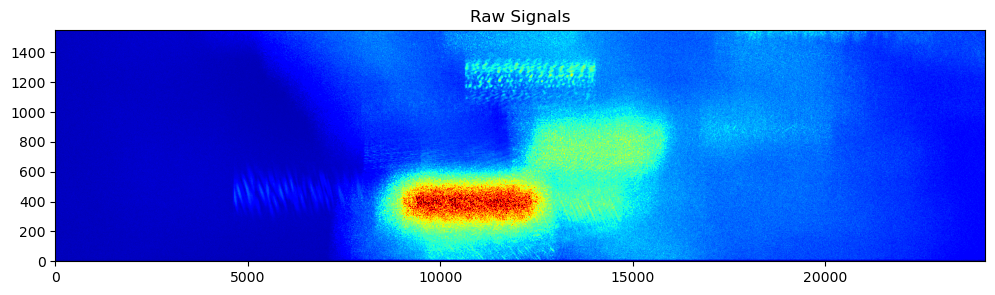

In [13]:
plot_signals(signals, do_pop_out=False, title='Raw Signals')

### Image Formation

In [14]:
replica_chirp = get_replica_chirp(burst_packets[0], num_rng)
range_compressed = ifftshift(ifft(range_compress_burst(signals, replica_chirp, do_2d=False), axis=1), 1)
range_compressed_spread = range_spreading_loss_correction(range_compressed, slant_ranges)
range_doppler = fftshift(fft(range_compressed_spread, num_az, axis=0), 0)

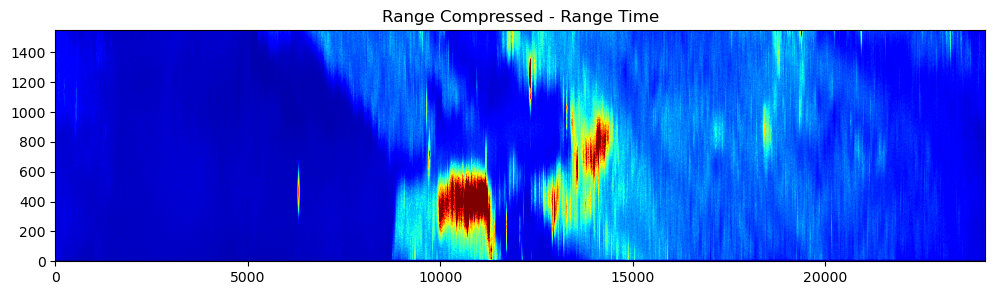

In [15]:
plot_signals(range_compressed, title='Range Compressed - Range Time', do_pop_out=False)

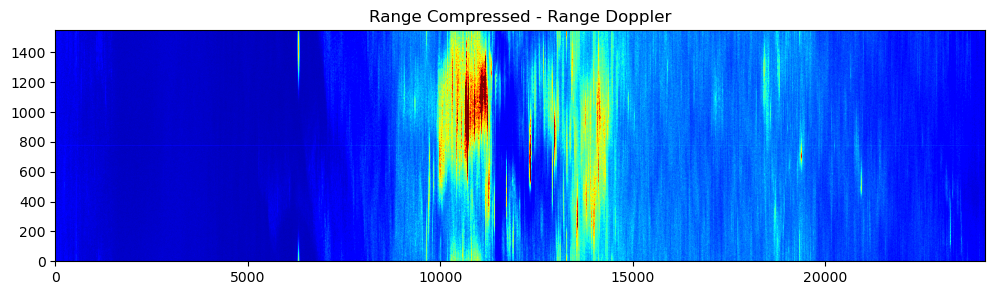

In [16]:
plot_signals(range_doppler, title='Range Compressed - Range Doppler')

In [17]:
az_freqs = np.linspace(f_dc-prf/2, f_dc+prf/2, num_az).T
rcmc_factor = get_range_migration_factor_w_az_freqs(header, effective_velocities, az_freqs)
src = secondary_range_compression(range_doppler, header, rcmc_factor, effective_velocities, slant_ranges, az_freqs)
range_migrated = range_cell_migration_correction(src, rcmc_factor, header)
azimuth_compressed = azimuth_compression(range_migrated, rng_time_offsets, slant_ranges, rcmc_factor, az_freqs, steering_angles)

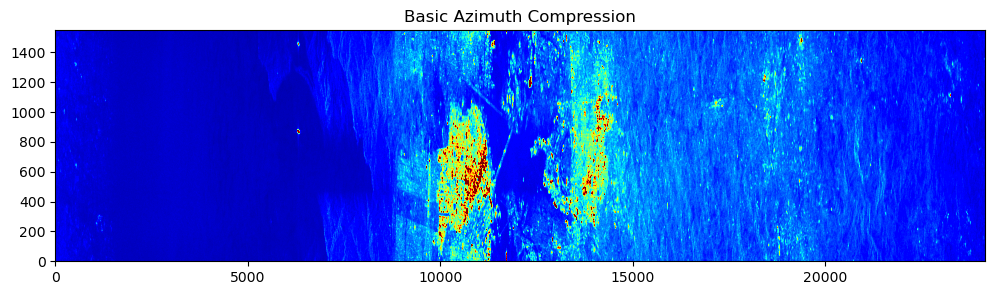

In [18]:
plot_signals(azimuth_compressed, do_pop_out=False, title='Basic Azimuth Compression')

In [19]:
ks = dc_rate
num_swaths = 3
T_b = az_times[-1] - az_times[0]
Ms = np.abs(ks * T_b / prf)
Tr = int(np.ceil(2 * T_b * num_az))
shape = int(np.ceil(Ms * num_az)) + Tr
PRF = prf
r_ref = (slant_range_end - slant_range_start) / 2
f_ref = evaluate_doppler_centroid(c_data, r_ref, r_ref)
T_b = prf / num_az
B_s = estimate_optimal_Bs(dc_rate, T_b, prf)

In [20]:
Ms = np.abs(ks*T_b/prf)

shape = int(np.floor(Ms*num_az))

# r_ref = (slant_range_end - slant_range_start) / 2
# f_ref = evaluate_doppler_centroid(c_data, r_ref, r_ref)
f_ref = f_dc
T_b = az_times[-1] - az_times[0]
B_s = estimate_optimal_Bs(dc_rate, T_b, prf)

ref_burst_packet_pairs = get_packets_in_burst(swath_packets, 5)[num_az//2]
ref_time = datetime_to_seconds([azimuth_times[ref_burst_packet_pairs[1]]])[0]
rng_times = get_slant_range_times(header, num_rng)
ref_times = (az_times[num_az//2] + rng_times) - ref_time

az_freqs = np.linspace(f_ref-Ms*prf/2, f_ref+Ms*prf/2, shape).T

vr = np.zeros((num_rng, shape), dtype=complex)
for i in range(effective_velocities.shape[0]):
    interp = interp1d(np.linspace(0, 1, effective_velocities.shape[1]), effective_velocities[i, :], kind='linear')
    vr[i, :] = interp(np.linspace(0, 1, shape))

D = get_range_migration_factor_w_az_freqs(header, vr, az_freqs)
ka = (-(2 * vr.T**2 * D**3) / (s1_wavelength * slant_ranges))
vs = np.asarray([np.linalg.norm(v) for v in velocities])
interp = interp1d(np.linspace(0, 1, num_az), vs, kind='linear')
vs_up = interp(np.linspace(0, 1, shape))**2
kr = -2 * vs_up / (s1_wavelength * slant_ranges[:, np.newaxis])

chirp_deramp = np.exp(-1j * pi * (1/ks) * (az_freqs-f_dc[:, np.newaxis])**2).T

o_shape = shape

vr = np.zeros((num_rng, o_shape), dtype=complex)
for i in range(effective_velocities.shape[0]):
    interp = interp1d(np.linspace(0, 1, effective_velocities.shape[1]), effective_velocities[i, :], kind='linear')
    vr[i, :] = interp(np.linspace(0, 1, o_shape))

az_freqs = np.linspace(f_ref-Ms*prf/2, f_ref+Ms*prf/2, o_shape).T
D = get_range_migration_factor_w_az_freqs(header, vr, az_freqs)
ka = (-(2 * vr.T**2 * D**3) / (s1_wavelength * slant_ranges))

chirp_reramp = np.exp(1j * pi * (1/ks) * (az_freqs-f_dc[:, np.newaxis])**2).T

In [21]:
processed = np.zeros((o_shape, num_rng), dtype=complex)

for rng_line in range(num_rng):
    az_shape = int(np.ceil(Ms)) * num_az

    tiled = np.zeros((shape,), dtype=complex)

    offset = int(np.floor(Ms))

    for i in range(offset):
        tiled[i*num_az:i*num_az + num_az] = range_doppler[:, rng_line]

    if Ms % 1 != 0:
        offset = int(np.floor(Ms))
        num_samples = int(np.floor((Ms % 1) * num_az))
        tiled[offset*num_az:offset*num_az+num_samples] = range_doppler[:num_samples, rng_line]

    deramped = tiled * chirp_deramp[:, rng_line]

    mid = shape // 2
    start = mid - int((prf*0.6) // 2)
    end = start + int((prf*0.6) // 2)

    filtered = np.zeros_like(deramped)
    filtered[:end-start] = fft(deramped)[start:end]
    filtered = ifft(filtered) / tiled.size

    interp = interp1d(np.linspace(0, 1, tiled.size), filtered, kind='quadratic')
    resampled = interp(np.linspace(0, 1, o_shape))

    processed[:, rng_line] = resampled * chirp_reramp[:, rng_line]

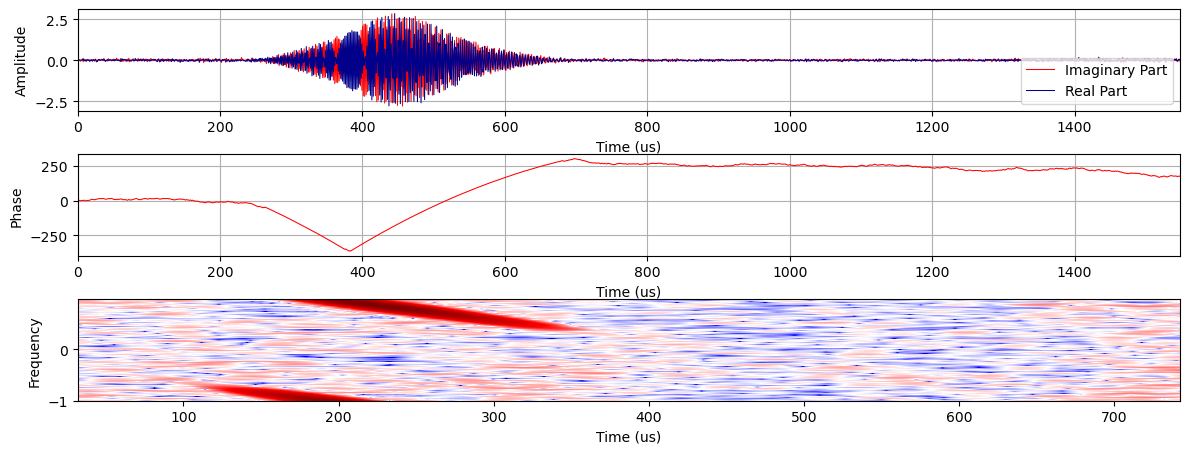

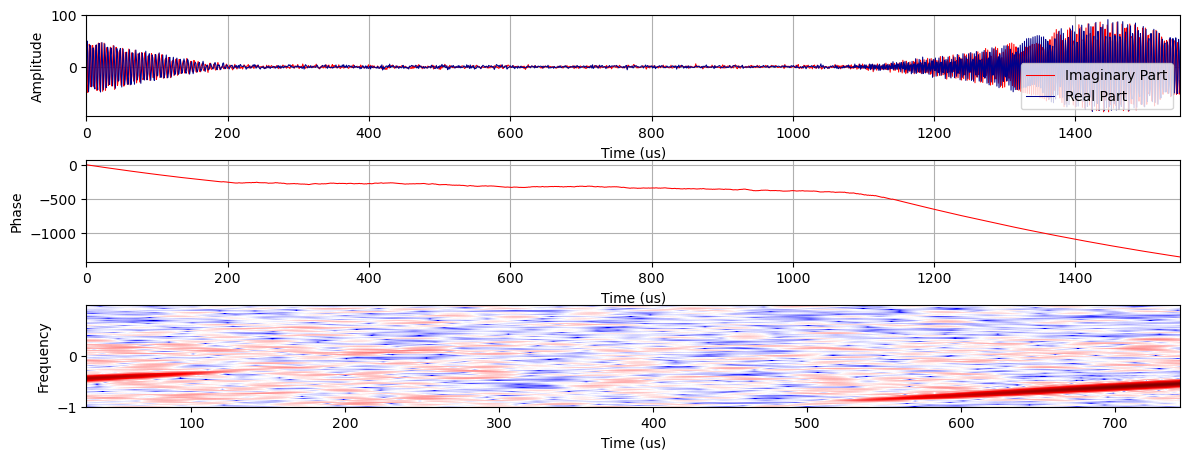

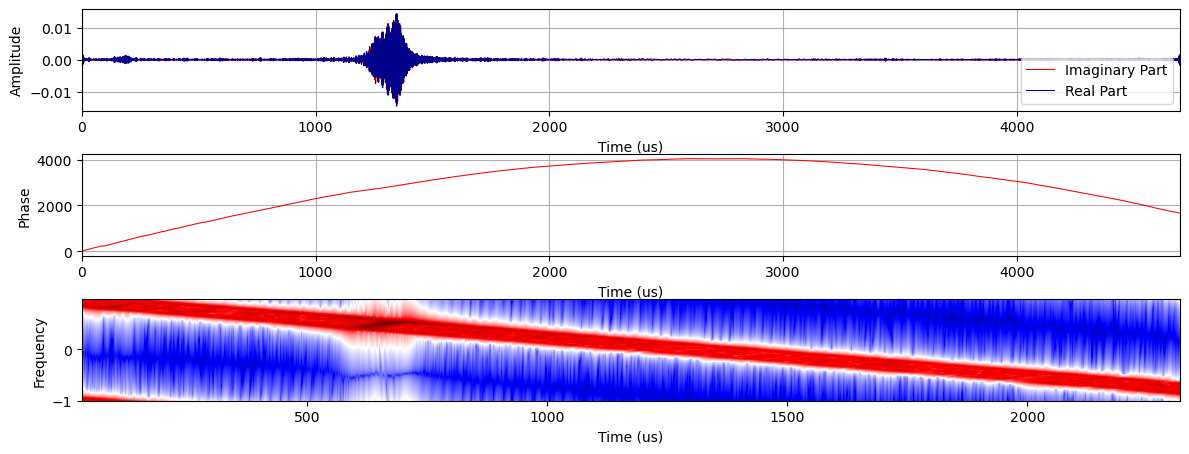

In [39]:
plot_signal_components(range_compressed[:, 6334])
plot_signal_components(range_doppler[:, 6334])
plot_signal_components(processed[:, 6334])

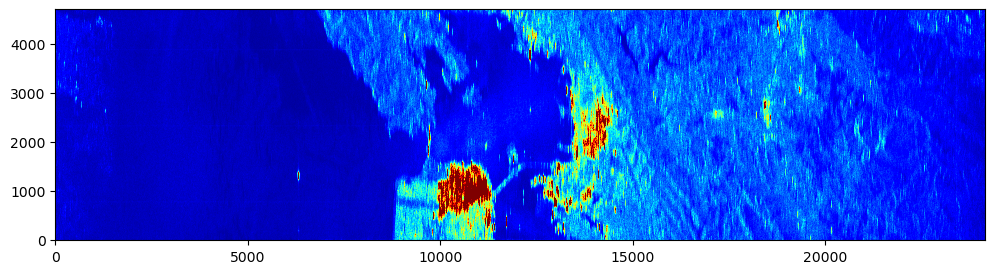

In [23]:
plot_signals(processed, do_pop_out=False)

In [24]:
shape = processed.shape[0]

steer_interp = interp1d(np.linspace(0, 1, num_az), steering_angles, kind='linear', fill_value='extrapolate')
steering_angles_up = steer_interp(np.linspace(0, 1, shape))

vr = np.zeros((num_rng, shape), dtype=complex)
for i in range(effective_velocities.shape[0]):
    interp = interp1d(np.linspace(0, 1, effective_velocities.shape[1]), effective_velocities[i, :], kind='linear')
    vr[i, :] = interp(np.linspace(0, 1, shape))

az_freqs = np.linspace(f_dc-Ms*prf/2, f_dc+Ms*prf/2, shape).T
rng_time_offset = rng_times - rng_times[0]
rcmc_factor = get_range_migration_factor_w_az_freqs(header, vr, az_freqs)

src = secondary_range_compression(processed, header, rcmc_factor, vr, slant_ranges, az_freqs)
range_migrated = range_cell_migration_correction(src, rcmc_factor, header)
src = None
azimuth_compressed = azimuth_compression(range_migrated, rng_time_offset, slant_ranges, rcmc_factor, az_freqs, steering_angles_up)
range_migrated = None
vr = None

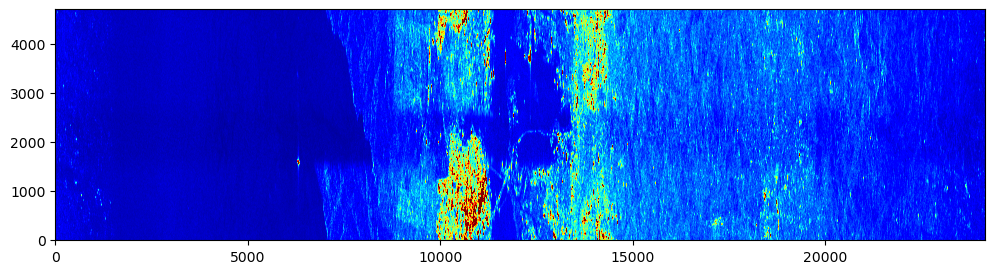

In [25]:
plot_signals(azimuth_compressed, do_pop_out=False)

In [26]:
num_tile = 2
num_out_samples = int(np.floor(num_az))
bandwidth = int(np.ceil(num_az*2*T_b))  # *Ms*T_b))

In [27]:
ufrshape = num_tile * processed.shape[0]

az_freqs_up = np.linspace(f_dc-prf*Ms/2, f_dc+prf*Ms/2, ufrshape).T

vr = np.zeros((num_rng, ufrshape), dtype=complex)
for i in range(effective_velocities.shape[0]):
    interp = interp1d(np.linspace(0, 1, effective_velocities.shape[1]), effective_velocities[i, :], kind='linear')
    vr[i, :] = interp(np.linspace(0, 1, ufrshape))

rcmc_factor = get_range_migration_factor_w_az_freqs(header, vr, az_freqs_up)
ka_up = (-(2 * vr.T**2 * rcmc_factor**3) / (s1_wavelength * slant_ranges))
ktp_up = -(ka_up * ks) / (ks - ka_up)

az_freqs_down = np.linspace(f_dc-prf*Ms/2, f_dc+prf*Ms/2, num_out_samples).T

vr = np.zeros((num_rng, num_out_samples), dtype=complex)
for i in range(effective_velocities.shape[0]):
    interp = interp1d(np.linspace(0, 1, effective_velocities.shape[1]), effective_velocities[i, :], kind='linear')
    vr[i, :] = interp(np.linspace(0, 1, num_out_samples))

rcmc_factor = get_range_migration_factor_w_az_freqs(header, vr, az_freqs_down)
ka_down = (-(2 * vr.T**2 * rcmc_factor**3) / (s1_wavelength * slant_ranges))
ktp_down = -(ka_down * ks) / (ks - ka_down)

rcmc_factor = None

In [28]:
output = np.zeros((num_out_samples, num_rng), dtype=complex)

for rng_line in range(num_rng):
    tiled = np.tile(azimuth_compressed[:, rng_line], num_tile)

    o_chirp_deramp = np.exp((-1j*pi*(az_freqs_up[rng_line]-f_dc[rng_line])**2 / ktp_up[:, rng_line]) + (2j*pi*(ktp_up[:, rng_line] + ka_up[:, rng_line])*(-f_dc[rng_line]/ka_up[:, rng_line])*((az_freqs_up[rng_line]-f_dc[rng_line]) / ktp_up[:, rng_line])))
    deramped = fftshift(tiled) * o_chirp_deramp

    mid = (tiled.size // 2)
    start = mid - (bandwidth//2)
    end = mid + (bandwidth//2)

    filtered = np.zeros_like(deramped)
    filtered = np.zeros_like(deramped)
    filtered[start:end] = fft(deramped)[start:end]
    filtered = ifft(ifftshift(filtered))

    interp = interp1d(np.linspace(0, 1, tiled.size), filtered, kind='quadratic', fill_value='extrapolate')
    resampled = interp(np.linspace(0, 1, num_out_samples))

    o_chirp_reramp = np.exp((1j*pi*(az_freqs_down[rng_line]-f_dc[rng_line])**2 / ktp_down[:, rng_line]) - (2j*pi*(ktp_down[:, rng_line] + ka_down[:, rng_line])*(-f_dc[rng_line]/ka_down[:, rng_line])*((az_freqs_down[rng_line]-f_dc[rng_line]) / ktp_down[:, rng_line])))

    output[:, rng_line] = resampled * o_chirp_reramp

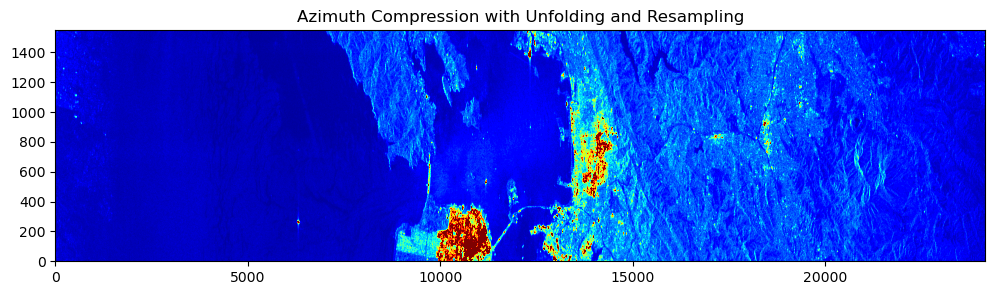

In [29]:
plot_signals(output, do_pop_out=False, title='Azimuth Compression with Unfolding and Resampling')

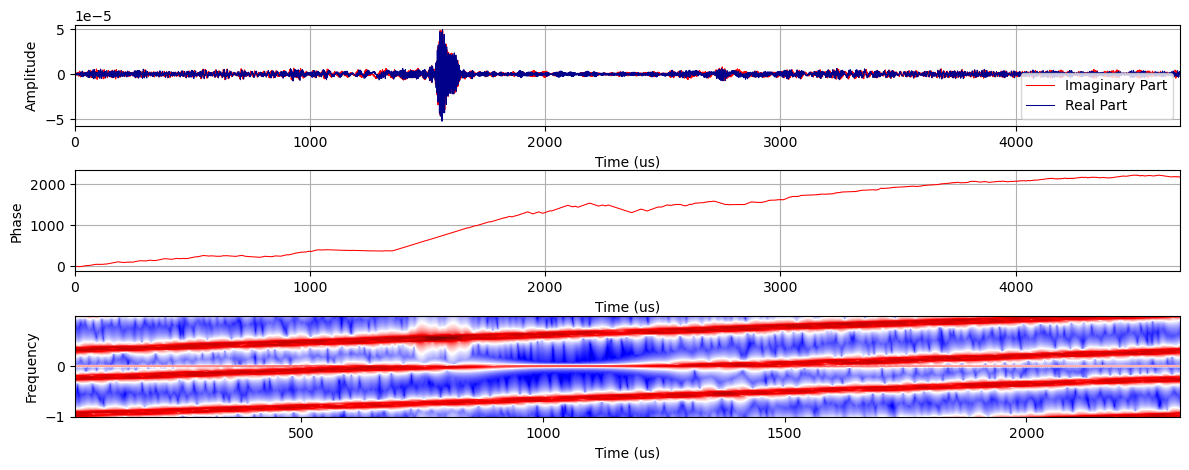

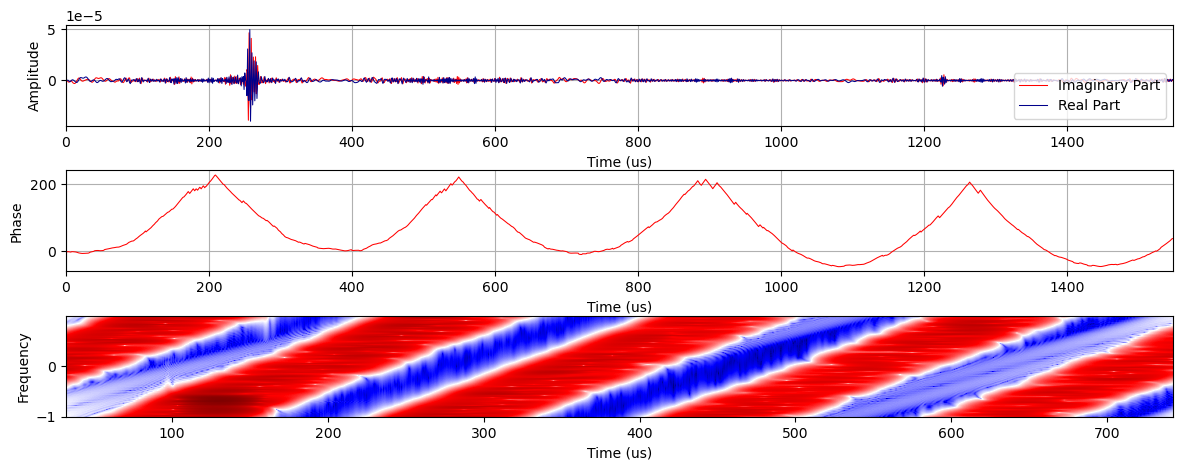

In [37]:
plot_signal_components(azimuth_compressed[:, 6334])
plot_signal_components(output[:, 6334])

In [31]:
save_image(output, 'output.tif')